# Setiment Analysis: BERT Model Preparation and Fine Tuninng
- Refer to [BERT_Sentiment_Analysis](https://colab.research.google.com/drive/1HABn0JGshF2TJGZmL061ABJgy8BvY1GE?usp=sharing) for sentiment classification or the unlabeled tweet dataset.

# NOTES and REFRENCES:
- This notebook can only be run on the [Colab](https://colab.research.google.com/drive/1FicAdDkFhe0rRobwbBSonmuNaSVFB3iZ?usp=sharing). Running this notebook require usage of GPU runtime. Set runtime to GPU by going to menue bar "Runtime/change runtime" and select GPU.


In [1]:
!nvidia-smi

Sun Nov 22 05:31:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

use cell below for TPU training ( Runtime must be changed to TPU)

In [ ]:
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

import below modules for TPU training only

In [ ]:
# imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 8.5MB/s 
     |████████████████████████████████| 1.1MB 30.5MB/s 
     |████████████████████████████████| 890kB 43.0MB/s 
     |████████████████████████████████| 2.9MB 47.6MB/s 


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
torch 1.7.0+cu101
transformers 3.5.1


In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import re
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)


rcParams['figure.figsize'] = 12, 8
random_seed=62
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Unclomment this line for TPU
# device =  xm.xla_device()

device

device(type='cuda', index=0)

## Import Training Dataset:
Training dataset is downloaded from Kaggle:
https://www.kaggle.com/kazanova/sentiment140 

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [6]:
!gdown --id 1AIVuiZoZcdHIzjEd0mz-sazu3Jy3OXm7

Downloading...
From: https://drive.google.com/uc?id=1AIVuiZoZcdHIzjEd0mz-sazu3Jy3OXm7
To: /content/training.1600000.processed.noemoticon.csv
239MB [00:01, 212MB/s]


In [7]:
data_encoding = "ISO-8859-1"
col_names = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding=data_encoding,names=col_names)

df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
%%time
# NOTE: trainig labels 0:negative,4:positive --> 0:negative,1:positive,2:neutral
label_dict = {0: 0, 2:2, 4:1}
def labels_to_sentiment(target):
  target = int(target)
  return label_dict[target]
df.target=df.target.apply(lambda x:labels_to_sentiment(x) )

CPU times: user 746 ms, sys: 4.34 ms, total: 750 ms
Wall time: 751 ms


## Dataset Content:
Dataset is consisted of 5 feature columns and 1 target columns:

target: Sentiment of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: tweet ids 

date: the date of the tweet

flag: The query (lyx)

user: tweeter handle (@user)

text: the text of the tweet

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'sentiment')

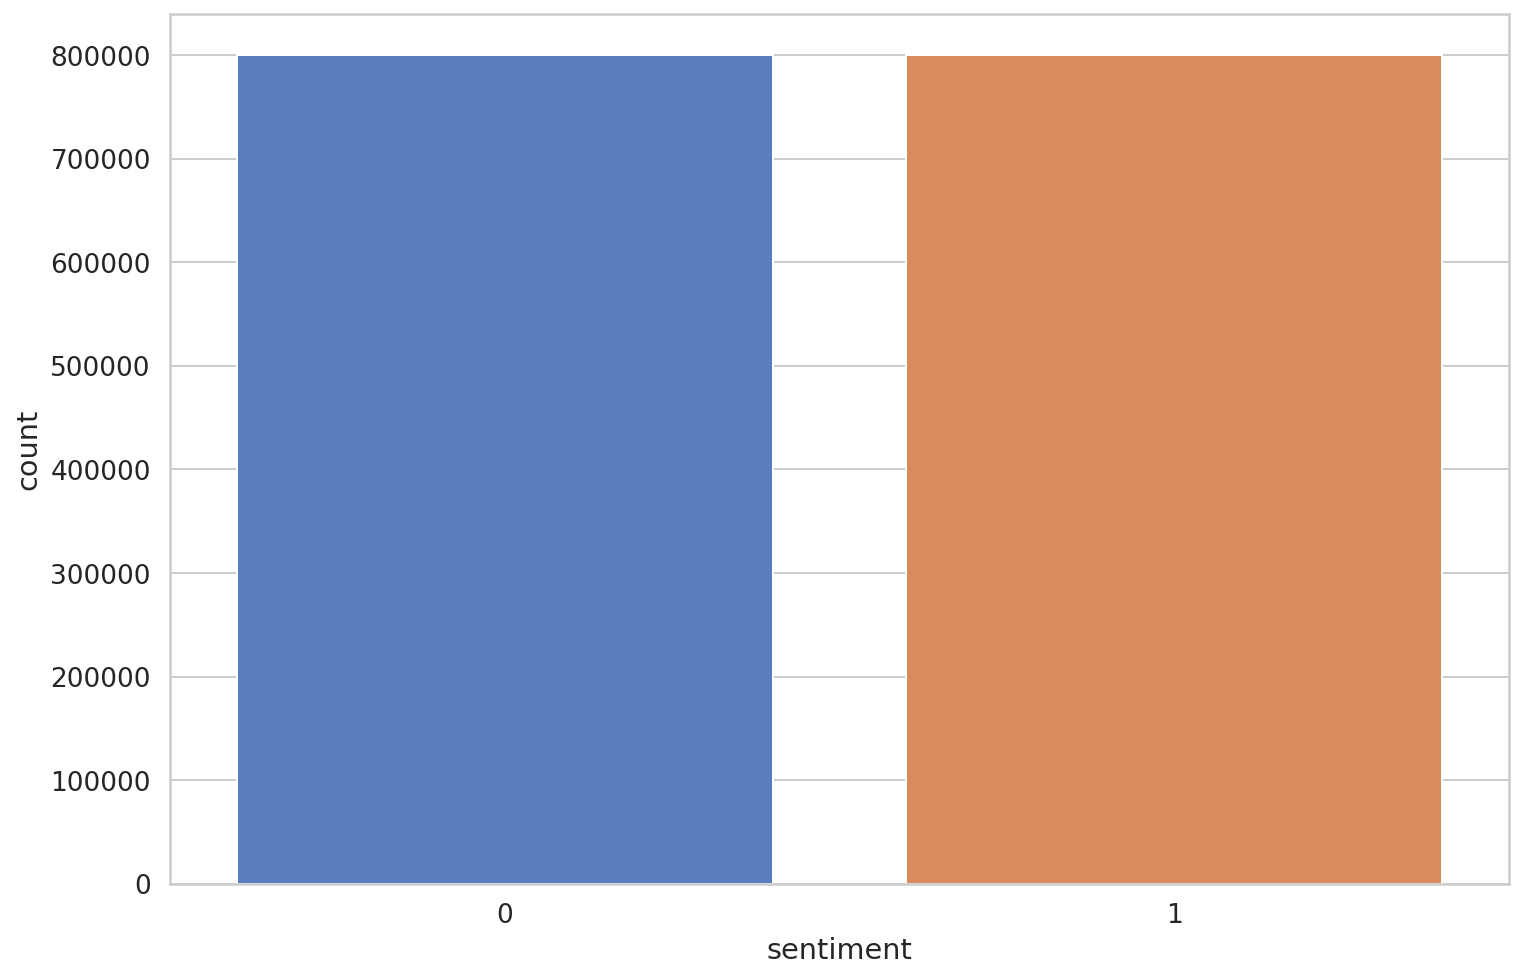

In [9]:
# Distribution of tweet sentiments
sns.countplot(df.target)
plt.xlabel('sentiment')

In [10]:
# Define the sentiment names
sentiment_names = ['negative', 'positive','neutral']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


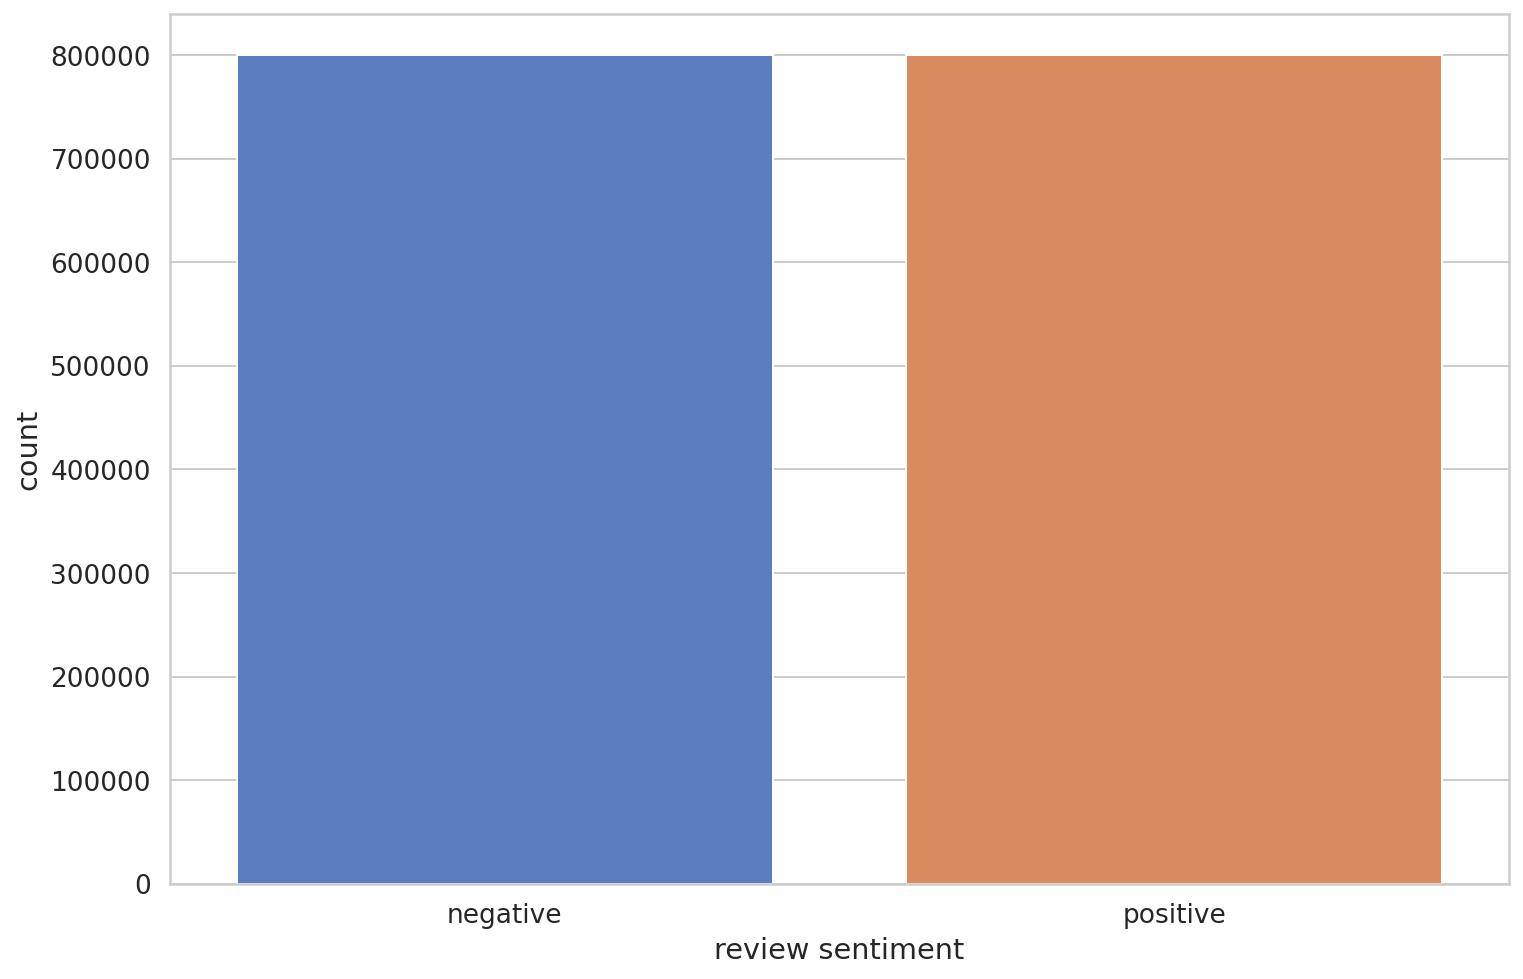

In [11]:
ax = sns.countplot(df.target)
plt.xlabel('review sentiment')
ax.set_xticklabels(sentiment_names);

## Data Preprosseing and Cleaning

In [ ]:
# Preprosseing
def preprocess_text(tweet):
    # replace links with 'url'
    tweet = re.sub(r'((https?:\/\/)|(www\.))[A-Za-z0-9.\/]+', 'url',  tweet)
    tweet = re.sub(r'[A-Za-z0-9]+.com', 'url',tweet)
    # remove , @users, if any
    tweet = re.sub(r'[@][A-Za-z0-9]+', '',tweet)
    # remove non-ascii characters
    tweet = ''.join([w for w in tweet if ord(w)<128])
    # hastags: bert tokenizer handle such tokens
    tweet = tweet.strip()
    return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Perform text processing on the dataset:

In [ ]:
# sample tweet before text processing
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess_text(x))

CPU times: user 22.5 s, sys: 166 ms, total: 22.7 s
Wall time: 22.7 s


In [ ]:
# sample tweet after text processing
df.text[0]

"url - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## BERT: Text Encoding

###Import tokenizer from Bert cased based model

In [ ]:
BERT_model_type = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_model_type)

In [ ]:
%%time
# Find the distribution of text length to select a maximum length for text encoding
lenght_of_token = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  lenght_of_token.append(len(tokens))

CPU times: user 6min 54s, sys: 49.4 ms, total: 6min 54s
Wall time: 6min 54s


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


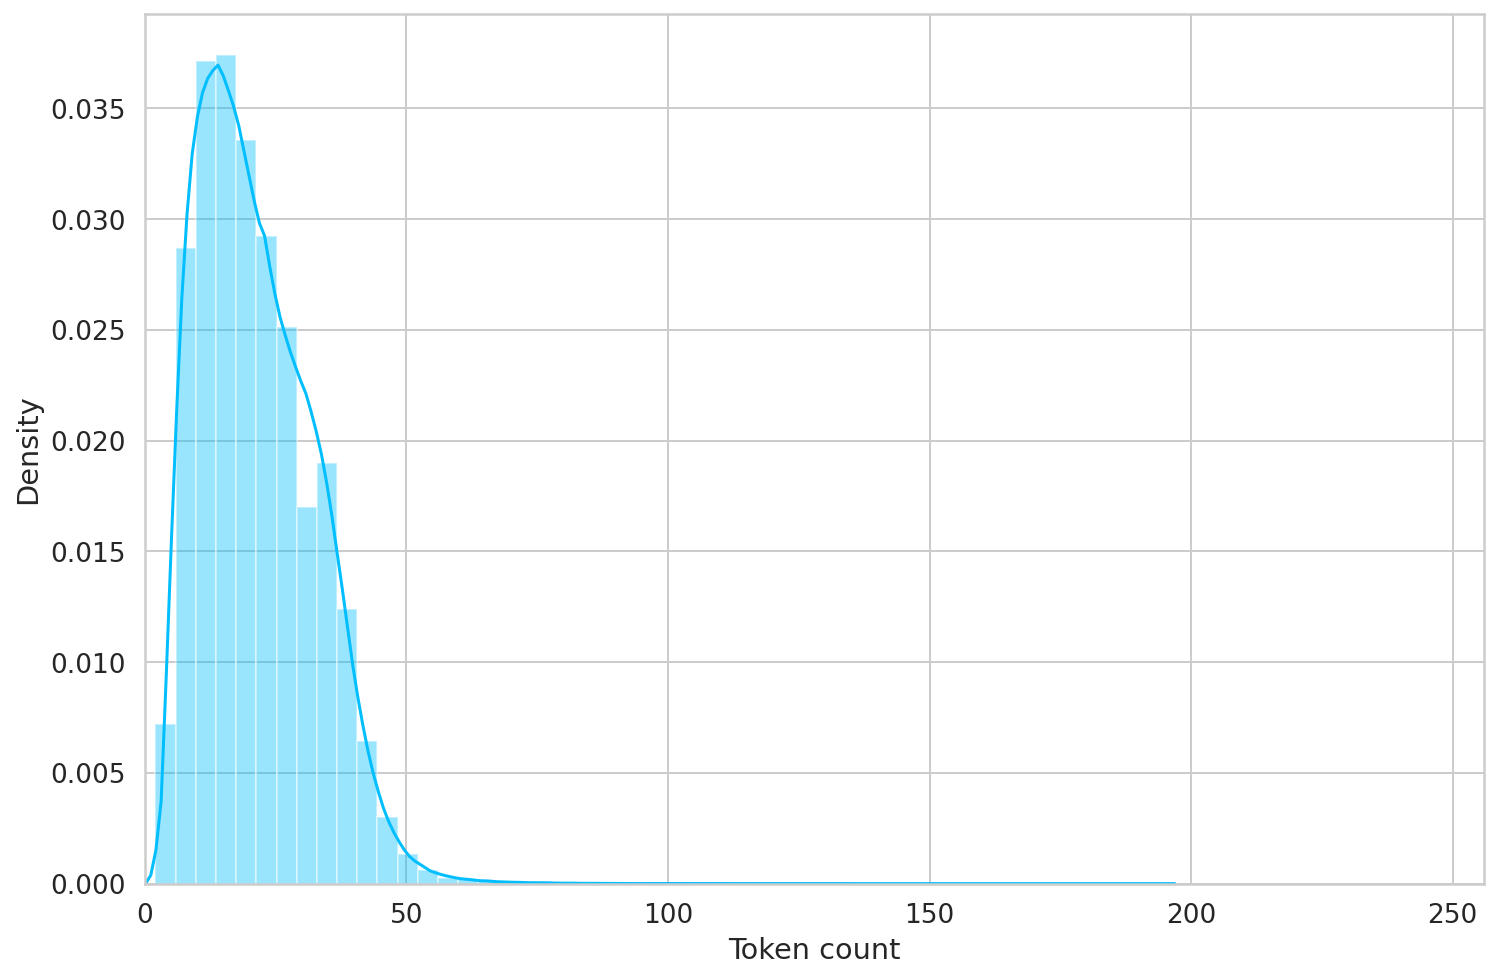

In [ ]:
# Plot the the distribution of text lengths
sns.distplot(lenght_of_token)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
# Based on the distribution of tweet lengths:
max_length = 65

In [ ]:
# Function to encode texts into tensor of tokens
class EncodeTweetData(Dataset):
  def __init__ (self,tweets,targets,tokenizer,max_length):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_length = max_length
    
    
  def __len__ (self):
    return len(self.tweets)

  def __getitem__(self,item):
    tweet_txt = str(self.tweets[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
          tweet_txt,
          max_length=self.max_length,
          truncation=True,
          add_special_tokens=True,
          return_token_type_ids=False,
          pad_to_max_length=True,
          # padding='longest',
          return_attention_mask=True,
          return_tensors='pt',
    )
    
    return {
          'tweet_text': tweet_txt,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
    }


## Train,Validation and Test set:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=random_seed)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((1280000, 6), (160000, 6), (160000, 6))

In [ ]:
# Function that performs text encoding and creat a dataloader
def make_data_loader(df, tokenizer, max_len, batch_size):
    ds = EncodeTweetData(
    tweets = df.text.to_numpy(),
    targets = df.target.to_numpy(),
    tokenizer = tokenizer,
    max_length = max_len
  )

    return DataLoader(ds,batch_size=batch_size,num_workers=4)

Batch size of 16 is selected based on the assumption in the trainig and recommendions of BERT model authors

In [ ]:
batch_size = 16
# Creating dataloader objects for train,validation and test set
train_data_loader = make_data_loader(df_train, tokenizer, max_length, batch_size)
val_data_loader = make_data_loader(df_val, tokenizer, max_length, batch_size)
test_data_loader = make_data_loader(df_test, tokenizer, max_length, batch_size)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

## Importing BERT model:

In [ ]:
bert_model = BertModel.from_pretrained(BERT_model_type)

In [ ]:
# Class to perform sentiment classification
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(BERT_model_type)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

# Model:
creating a model and transfering it to GPU

In [ ]:
model = SentimentClassifier(len(sentiment_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
# batchxmax_length
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 65])
torch.Size([16, 65])


# Trainig

AdamW optimizer from Huggin Face was used to match the original trainig method of the BERT paper.
Hyper parameter tuning was performed using the recommendations of the BERT paper and the following final parameters was used :
- Batch size: 16 (Recommended: 16, 32)
- Learning rate (Adam): 2e-5 (Recommended: 5e-5, 3e-5, 2e-5)
- Number of epochs: 2 (Recommended:2, 3, 4)


Note: Each epoch of this model will take about 4.5 hours and due to GPU usage limitaion of the google colab free version a model checkpoint is saved at each epoch to continue the trainig in a susequent scession. Final version of the model was trained for 2 epochs per recommendition of the BERT paper authors.

In [ ]:
EPOCHS = 2
last_epoch =0
# Optimizer AdamW to match the original BERT paper
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
# Loss function
loss_function = nn.CrossEntropyLoss().to(device)
# total number of trainig steps
max_steps = len(train_data_loader) * EPOCHS

# scheduler
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=max_steps
)


In [ ]:
def train_model(model, data_loader, loss_function, optimizer, device, scheduler, n_samples):
  # train the model
  model = model.train()

  losses = []
  num_correct_pred = 0
  
  for data in data_loader:
    input_ids = data["input_ids"].to(device)
    attention_mask = data["attention_mask"].to(device)
    targets = data["targets"].to(device)

    outputs = model(input_ids=input_ids,attention_mask=attention_mask)

    _, preditions = torch.max(outputs, dim=1)
    loss = loss_function(outputs, targets)
    num_correct_pred += torch.sum(preditions == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
  correct_ratio = num_correct_pred.double() / n_samples
  avg_loss = np.mean(losses)

  return correct_ratio, avg_loss

In [ ]:
def evaluate_model(model, data_loader, loss_function, device, n_samples):
  model = model.eval()

  losses = []
  num_correct_pred = 0

  with torch.no_grad():
    for data in data_loader:
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["targets"].to(device)

      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preditions = torch.max(outputs, dim=1)

      loss = loss_function(outputs, targets)

      num_correct_pred += torch.sum(preditions == targets)
      losses.append(loss.item())

  correct_ratio = num_correct_pred.double() / n_samples
  avg_loss = np.mean(losses)

  return correct_ratio, avg_loss

### !!!
# Since the model is already trained the next cells in this section can be skipped and in Evaluation section by downloading the best model state of the trained model the test set evaluation can be reproduced 

### Continue Training: 
Model check point can be downloaded and trainig will continue where it left off, otherwise the following two cells should be commneted out so the trainig can start from the begining. (Current out put is for the the end of epoch 2)

In [ ]:
# Load checkpoint to continue training if exist
# download checkpoint from drive 
# Model checkpoint at end of  epoch 1:
# !gdown --id 1q5JIFShQUJiZG_BrRuQqUEJo9U-LpmbU
# Model checkpoint at end of  epoch 2:
# !gdown --id 1alaDfFsBbJ9WiTkKFdKkERCfb022Ai7E

Downloading...
From: https://drive.google.com/uc?id=1q5JIFShQUJiZG_BrRuQqUEJo9U-LpmbU
To: /content/model_checkpoint.pth
1.30GB [00:07, 177MB/s]


In [ ]:
# PATH='/content/model_checkpoint.pth'
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# last_epoch = checkpoint['epoch']

###!!!!!! Run the following cell to start/continue training or skip to Evaluation section to import the previously trained model ###

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
from time import time
from google.colab import files


for epoch in range(last_epoch,EPOCHS):
  start = time()
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_model(model,train_data_loader, loss_function, optimizer,device, scheduler,len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  validation_acc, validation_loss = evaluate_model(model,val_data_loader,loss_function,device,len(df_val))

  print(f'Validation loss {validation_loss} accuracy {validation_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(validation_acc)
  history['val_loss'].append(validation_loss)
  
  checkpoint = {
      'epoch': epoch+1,
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict()
  }
  print(f"checkpoint @ epoch={epoch+1}")
  torch.save(checkpoint, 'model_checkpoint.pth')
  if validation_acc > best_accuracy:
    print(f'epoch={epoch+1} is being saved as best model')
    torch.save(model.state_dict(), 'best_model_state.pth')
    best_accuracy = validation_acc
  print(f'time for epoch={epoch+1}, {time()-start}')
  print()
    

Epoch 2/2
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.2606962282997454 accuracy 0.89961875


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.321745760865882 accuracy 0.8640562500000001

checkpoint @ epoch=2
epoch=2 is being saved as best model
time for epoch=2, 18965.525626659393

CPU times: user 3h 32min 23s, sys: 1h 40min 30s, total: 5h 12min 54s
Wall time: 5h 16min 5s


### Download Model state and checkpoint after training:

In [ ]:
# download best model state file
from google.colab import files
files.download('best_model_state.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# download checkpoint file
files.download('model_checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Best accuracy of the model on the validation set:

In [ ]:
best_accuracy

tensor(0.8641, device='cuda:0', dtype=torch.float64)

Best accuracy of the model on the trainig set:

In [ ]:
history['train_acc']

[tensor(0.8996, device='cuda:0', dtype=torch.float64)]

# Evaluation:
Use the two commented cells below if you want to import the best model state and evaluate it on test set

Download the best state of the model:

In [ ]:
## This is the best state of the trained model (best_model_state_e1.pth)
## to use any other model, upload the model in the cell below and comment the download code below
# !gdown --id 1afvHvYRK2qvOMk-oVF6KDYrIO6hpUAik

Or upload a different model state

In [ ]:
# uploaded = files.upload()

Saving best_model_state.bin to best_model_state.bin


Creat a instance of the model using the imported model state

In [ ]:
# model = SentimentClassifier(len(sentiment_names))
# model.load_state_dict(torch.load('best_model_state_e1.pth'))
# model = model.to(device)

### Evaluating Test Set:

In [ ]:
%%time
test_acc, _ = evaluate_model(model,test_data_loader,loss_function,device,len(df_test))

test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

CPU times: user 7min 57s, sys: 4min 27s, total: 12min 25s
Wall time: 12min 29s


## Test set accuracy:

In [ ]:
test_acc.item()

0.8658125000000001

In [ ]:
def model_predict(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for data in data_loader:
      # Move to GPU
      texts = data["tweet_text"]
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["targets"].to(device)


      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      probabilities = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probabilities)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [ ]:
%%time
y_tweet_texts, y_pred, y_pred_probs, y_test = model_predict(model,test_data_loader)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

CPU times: user 7min 40s, sys: 4min 46s, total: 12min 27s
Wall time: 12min 31s


## Confusion Matrix

In [ ]:
print(classification_report(y_test, y_pred, target_names=sentiment_names[:-1]))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.87     80025
    positive       0.87      0.86      0.87     79975

    accuracy                           0.87    160000
   macro avg       0.87      0.87      0.87    160000
weighted avg       0.87      0.87      0.87    160000



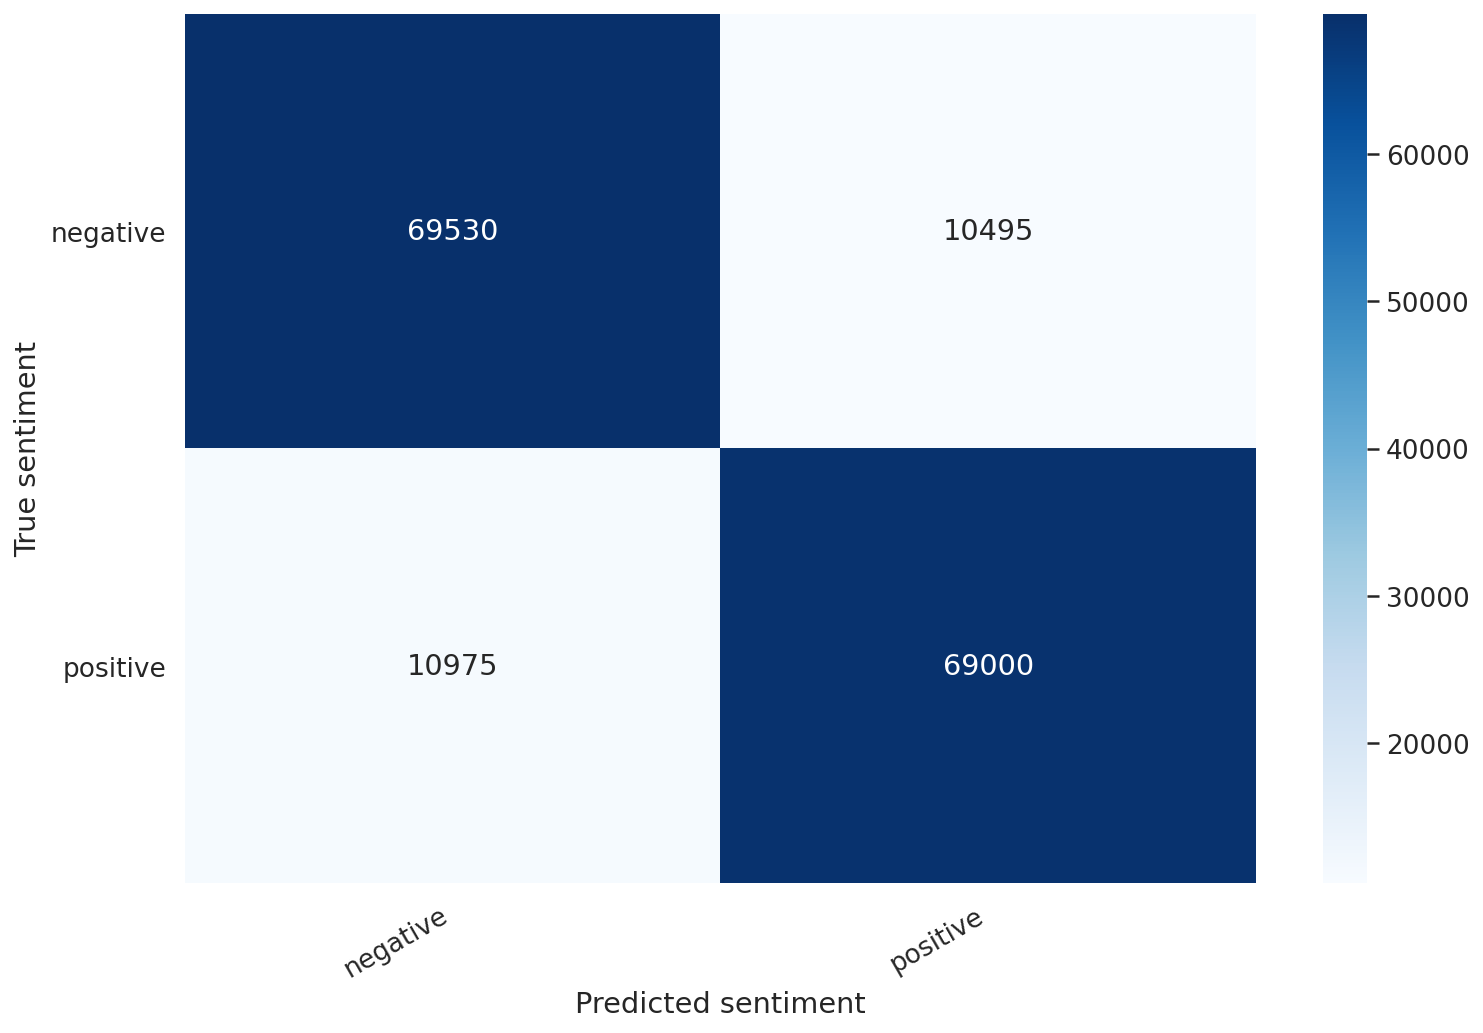

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=sentiment_names[:-1], columns=sentiment_names[:-1])
show_confusion_matrix(df_cm)

# Examples of sentiment analysis:

In [ ]:
idx = 99
# Sample Tweet from the test set
tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': sentiment_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(tweet_text)))
print()
print(f'sentiment: {sentiment_names[true_sentiment]}')

doing hoework...

True sentiment: negative


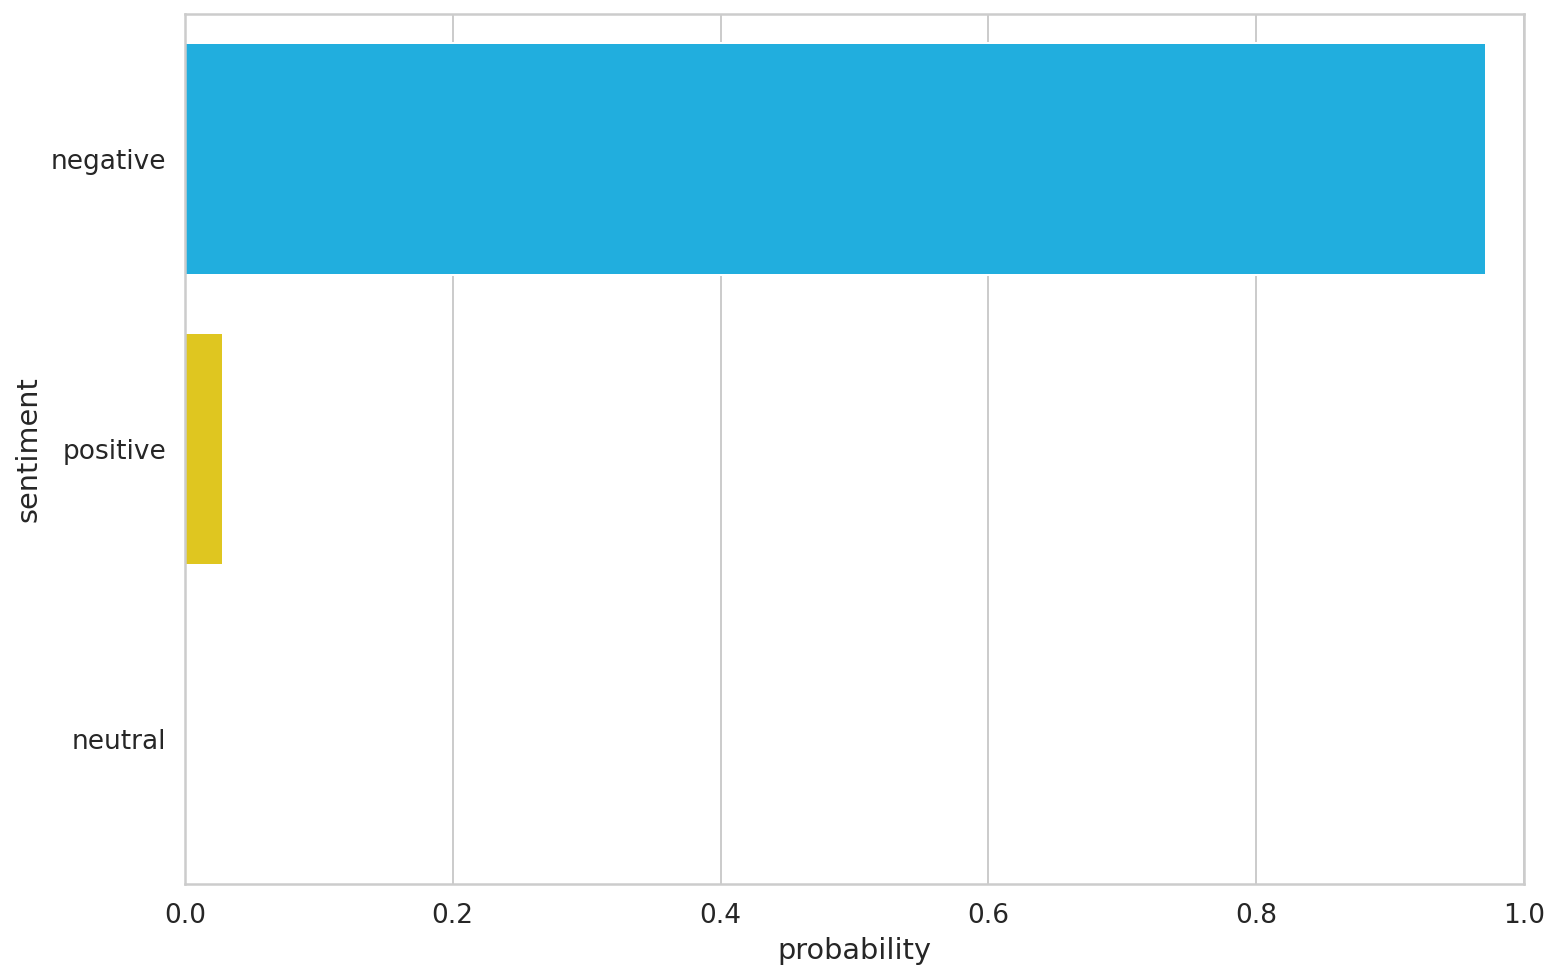

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
# Sample Text: Replace with your own for testing

In [ ]:
tweet_text ="we need to figure this thing out"

In [ ]:
# Using the tokenizer to encode the tweet:
encoded_tweet= tokenizer.encode_plus(
  tweet_text,
  max_length=max_length,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tweet text: doing hoework...
Sentiment  : negative
predictions  : tensor([0])
prediction_probs  :   class_names        values
0    negative  9.712333e-01
1    positive  2.876674e-02
2     neutral  1.375822e-08


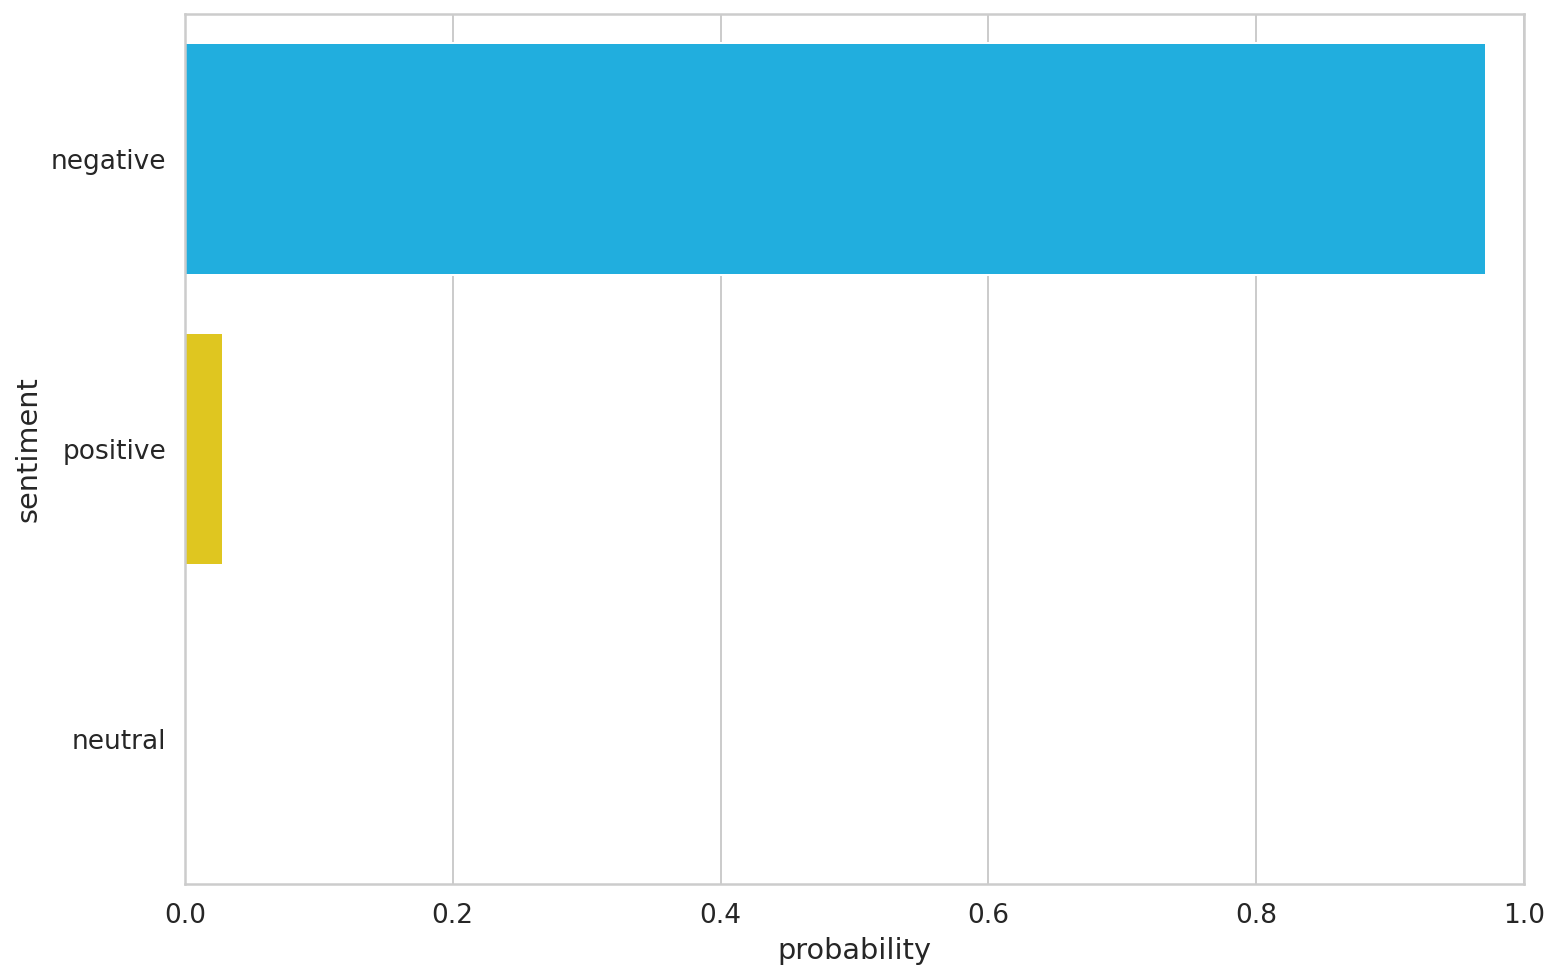

In [ ]:
# Using model to get the sentiment probability and predition
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
tweet_texts = []
predictions = []
prediction_probs = []
real_values = []

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

with torch.no_grad():
  probs = F.softmax(output, dim=1)

  tweet_texts.extend(tweet_text)
  predictions.extend(prediction)
  prediction_probs.extend(probs)
  # real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
pred_df = pd.DataFrame({
  'class_names': sentiment_names,
  'values': prediction_probs[0]
})
# real_values = torch.stack(real_values).cpu()

print(f'Tweet text: {tweet_text}')
print(f'Sentiment  : {sentiment_names[prediction]}')

print(f'predictions  : {predictions}')
print(f'prediction_probs  : {pred_df}')

sns.barplot(x='values', y='class_names', data = pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);